# IMDB Review
Given a IMDB movie review, classify it as positive or negative. Basically, it is a sentiment analysis.  

For doing so, I have used Bidirectional LSTM with Attention for better understanding the context of the review.  

This notebook is divided into the following sections:
* Importing the libraries
* Importing the dataset
* Text Preprocessing
* Attention
* Building the model
* Training
* Testing
***
### Importing the libraries
The cell below is for importing the required libraries and for silencing the warnings

In [1]:
# !pip install tensorflow==1.14

In [2]:
# import numpy as np 
# with open('/kaggle/input/data-sentiment-foody-vn/data_train/data_train/train/neg/1.txt', encoding="utf8") as f:
#     lines = f.readlines()
#     lines = "".join(lines)
# print(lines)
# print(type(lines))
# print(np.shape(lines))

In [3]:
import os

In [4]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 44.4 MB/s eta 0:00:00


In [5]:
#Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, unicodedata
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras import backend
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf

from pyvi import ViTokenizer
from pyvi import ViUtils

### Importing the dataset
***

# df1

In [6]:
df1 = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv')
df1 = df1.dropna()

df1 = df1.drop(['Unnamed: 0','RevId','UserId','image_urls'], axis=1)
X_train1 = list(df1['Comment'].values)
y_train1 = list(df1['Rating'].values)
print(df1.shape)
df1.head()

(9070, 2)


,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1.0
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0.0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1.0
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0.0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1.0


## df2

In [7]:
# df2 = pd.read_csv('/kaggle/input/50k-data/data_1.csv')
# df2 = df2.dropna()
# df2 = df2.drop(['Score','RevId'], axis=1)
# X_train2 = list(df2['Comment'].values)
# y_train2 = list(df2['Rating'].values)
# print(df2.shape)
# df2.head()

# df3


In [8]:
# df3 = pd.read_csv('/kaggle/input/data-100k/extra_150k.csv')
# df3 = df3.dropna()
# # df2 = df2.drop(['Score','RevId'], axis=1)
# X_train3 = list(df3['Comment'].values)
# y_train3 = list(df3['Rating'].values)
# print(df3.shape)
# df2.head()

In [9]:
X_train = X_train1 #+ X_train2 + X_train3
print(len(X_train))
y_train = y_train1 #+ y_train2 + y_train3

9070


In [10]:
sum(y_train)

7146.0

In [11]:
sum(y_train)/len(y_train)

0.7878721058434399

<AxesSubplot:ylabel='count'>

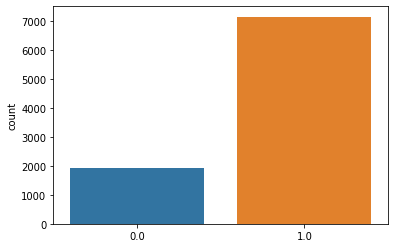

In [12]:
sns.countplot(y_train)


### Text Preprocessing
***
Preprocessing the text so as to have a better data for our model.  
It comprises of steps such as removing non-ASCII characters, removing HTML tags, converting to lower-case, lemmatizing.

In [13]:
def clean_text_2(text):
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = RE_EMOJI.sub(r'', text)
    return text.strip().lower()

In [14]:
# stopwords_vn = []
# src = '/kaggle/input/vietnamesestopword/vietnamese-stopwords.txt'
# with open(src,'r', encoding = 'utf-8') as f:
#     for line in f:
#         stopwords_vn.append(line.strip())

In [15]:
def tokenizer_vn(text):
    text = ViTokenizer.tokenize(text)
    return text

In [16]:
# stopwords_vn = [tokenizer_vn(word) for word in stopwords_vn]
# def remove_stopwords(text):
#     text = text.split()
#     text = [word for word in text if word not in stopwords_vn]
#     return ' '.join(text)

In [17]:
def clean_text(X):
    processed = []
    for text in X:
        text = clean_text_2(text)
        text = ViTokenizer.tokenize(text)
        processed.append(text)
    return processed

Preprocessing the Training Set and Test set

In [18]:
text_test = X_train[13]
print(text_test)

Quán được toạ ngay vị trí đối diện là trung tâm nhà hát lớn. Ở ngay đầu ngõ nên dễ tìm, không khí khá yên tĩnh không ồn ào. Quán mới nâng cấp bàn ghế, có điều hoà mát rượi, tạo cảm giác không gian sang trọng và lịch thiệp. Có thể ngồi ngoài ngõ. Menu rất nhiều món ốc, đậm chất sài gòn luôn. Nhưng so với bọn sinh viên mình thì thực sự giá hơi chát. 😓😓😓 ăn cũng được, lạ miệng. Chị nhân viên phục vụ cũng tạm, mặt hơi lạnh lùng 😒😒😒 nói chung là đến để ăn thử vì nghe tên rất lâu rồi, chứ ko dám quay lại vì khá tốn kém :))


In [26]:
# test2 = tokenizer_vn(clean_text_2(text_test))
# print(test2)

In [20]:
# test2 = remove_stopwords(clean_text_2(text_test))
# print(test2)

In [21]:
# test2 = remove_stopwords(tokenizer_vn(clean_text_2(text_test)))
# print(test2)

In [22]:
# X_train_final,y_train = clean_text(X_train), y_train
# X_test_final,y_test = clean_text(X_test,y_test)

In [24]:
#clean_text_load = pd.read_csv('/kaggle/input/data-clean100k/data_clean.csv')
#clean_text_load = clean_text_load.dropna()

In [27]:
# clean_text_load.head()

In [ ]:
# clean_text_load.shape

In [28]:
# X_train_final = list(clean_text_load['Comment'].values)
# y_train = list(clean_text_load['Rating'].values)
X_train_final = X_train
#y_train 

In [30]:
len(X_train_final)

9070

# take 100

In [31]:
# my_data_new = pd.DataFrame({'Comment': X_train_final, 'Rating': y_train})
# my_data_new.to_csv('data_clean.csv', index=False)
# my_data_new.shape

In [32]:
print(X_train_final[:2])
print(y_train[:2])

['Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trông rất thích', 'Gọi ship 1 xuất cari gà bánh naan và 3 miếng gà nướng(được tặng 1 coca). Đồ ăn khá ngon, tổng 210k được giảm 50k còn 160k. Tuy nhiên gọi 3 miếng gà thì thiếu 1 miếng, mà kể cả đó đủ ba miếng thì khẩu phần vẫn là quá ít so với giá 120k 1 suất.']
[1.0, 0.0]


### Attention Layer
***

The basic concept of attention is that not all words contribute equally to the meaning of a sentence. Hence, their contribution must be weighted.  
How attention works is, it basically extracts words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector.

In [33]:
# Attention Layer
from tensorflow.keras import initializers,regularizers,constraints
from tensorflow.keras import backend as K
class AttentionWithContext(tf.keras.layers.Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
            })
        return config
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

Some Useful Variables  


In [34]:
#Tokenization and Padding
vocab_size = 60000
maxlen = 250
encode_dim = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_final)
tokenized_word_list = tokenizer.texts_to_sequences(X_train_final)
X_train_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')

In [35]:
# print(np.shape(X_train_padded))
# print(np.shape(X_train_final))

**EarlyStopping**  
It can be used to prevent overfitting.It basically waits a few epochs (5), monitoring the loss for the validation dataset.If the loss doesn't decrease for 2 epochs, it stops the training process.

**ModelCheckpoint**  
It is used for saving the best model during training. After each epoch, it takes a look at the Validation accuracy, if it improves globally, this is the best model we have seen till now during the training process and hence, saves it.

In [36]:
#EarlyStopping and ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('model_best.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

### Building the Model
***
The model used comprises of BiDirectional LSTM with Attention layer on top of it, followed by a dense layer and finally a dense layer with sigmoid activation function to get the sentiment or the class.  
Optimiser used is ADAM

In [37]:
from tensorflow.keras import layers

In [38]:
# Building the model
def create_model():
    model = Sequential()
    embed = Embedding(input_dim = vocab_size, output_dim = 20, input_length = X_train_padded.shape[1]
    #                   , dropout = 0.4
                     ) 
    model.add(embed)
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(200, return_sequences = True)))
    # model.add(Dropout(0.3))
    # model.add(Bidirectional(GRU(200, return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(AttentionWithContext())
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    return model


### Training
***
Splitting the Training set into Training set and Validation set

## split

In [39]:
from sklearn.model_selection import train_test_split
X_train_padded = np.asarray(X_train_padded)
y_train = np.asarray(y_train)
# X_train_final2, X_val, y_train_final2, y_val = train_test_split(X_train_padded, y_train, test_size = 0.1)
X_train_final2 = X_train_padded
y_train_final2 = y_train

In [40]:
print(type(X_train_final2))

<class 'numpy.ndarray'>


Training the model

In [41]:
y_train_final2.shape

(9070,)

In [42]:
weight = sum(y_train_final2) / y_train_final2.shape[0]
print(weight)

0.7878721058434399


## weight

In [43]:
#class weight
weight_for_0 = (1 / (1-(weight))) * 0.5
weight_for_1 = (1 / (weight))* 0.5
class_weight = {0: weight_for_0, 1: weight_for_1}

In [44]:
print(tf. __version__) 

2.6.4


In [45]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('model_best.h5', monitor = 'f1_score', mode = 'min', verbose = 1, save_best_only = True)

In [46]:
batch_size= 300
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='f1_score', factor=0.2,
                              patience=3, min_lr=1e-5,verbose = 1)

In [47]:
import tensorflow_addons as tfa

# CPU

In [48]:
# optim =  tf.keras.optimizers.Adam(learning_rate=5e-4)

# model.compile(optimizer='adam',
#                      loss='binary_crossentropy',
#                      metrics=['accuracy',
# #                               tf.keras.metrics.Precision(),
#                               tf.keras.metrics.Recall(),
#                               tfa.metrics.F1Score(num_classes=1,
#                                                  average='micro')
#                              ]
#              )

# TPU

In [49]:
# tpu_strategy = tf.distribute.MirroredStrategy()
tpu_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])



2022-12-01 16:47:24.921446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 16:47:24.922436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 16:47:25.254730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 16:47:25.255638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 16:47:25.256510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [50]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# print(tpu)
# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
tpu_strategy = tf.distribute.MirroredStrategy()

# # instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = create_model() # define your model normally
    optim =  tf.keras.optimizers.Adam(learning_rate=5e-4)

    model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy',
#                               tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=1,
                                                 average='micro')
                             ]
             )



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 20)           1200000   
_________________________________________________________________
dropout (Dropout)            (None, 250, 20)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 400)          353600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 400)          0         
_________________________________________________________________
attention_with_context (Atte (None, 400)               160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

In [51]:
len(X_train_final2)

9070

In [52]:
train_x, train_y = np.array(X_train_final2), np.array(y_train_final2)
# val_x, val_y = np.array(...), np.array(...)

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# val_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))

In [53]:
train_x

array([[ 328,  441,   17, ...,    0,    0,    0],
       [  31,  234,   16, ...,    0,    0,    0],
       [ 527,  617,  370, ...,    0,    0,    0],
       ...,
       [ 170,  114,  117, ...,    0,    0,    0],
       [  99,    1,   74, ...,    0,    0,    0],
       [ 179,  311, 1109, ...,    0,    0,    0]], dtype=int32)

In [54]:
train_y

array([1., 0., 1., ..., 1., 1., 1.])

In [55]:
batch_size = 512 * tpu_strategy.num_replicas_in_sync

train_data = train_data.batch(batch_size)
# val_data = val_data.batch(batch_size)
# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
# val_data = val_data.with_options(options)

In [56]:
#Fitting the model
model.fit(train_data ,
          epochs = 15, batch_size = batch_size, verbose = 1,
#           validation_data = (X_val, y_val),
          callbacks = [reduce_lr, es,mc],class_weight=class_weight)

2022-12-01 16:47:31.700326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-01 16:47:43.337535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-01 16:47:44.370346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 18s 237ms/step - loss: 0.6920 - accuracy: 0.3531 - recall: 0.2333 - f1_score: 0.8814

Epoch 00001: f1_score improved from inf to 0.88135, saving model to model_best.h5
Epoch 2/15
9/9 [==============================] - 2s 236ms/step - loss: 0.6829 - accuracy: 0.5593 - recall: 0.5605 - f1_score: 0.8814

Epoch 00002: f1_score did not improve from 0.88135
Epoch 3/15
9/9 [==============================] - 2s 234ms/step - loss: 0.6249 - accuracy: 0.6387 - recall: 0.6117 - f1_score: 0.8814

Epoch 00003: f1_score did not improve from 0.88135
Epoch 4/15
9/9 [==============================] - 2s 234ms/step - loss: 0.4685 - accuracy: 0.8303 - recall: 0.8476 - f1_score: 0.8814

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00004: f1_score did not improve from 0.88135
Epoch 5/15
9/9 [==============================] - 2s 236ms/step - loss: 0.3840 - accuracy: 0.8774 - recall: 0.9053 - f1_score: 0.8814

Epoch 00005: f1_sc

In [57]:
# #Fitting the model
# batch_size = 512 #* tpu_strategy.num_replicas_in_sync
# model.fit(X_train_final2, y_train_final2, 
#           epochs = 15, batch_size = batch_size, verbose = 1,
# #           validation_data = (X_val, y_val),
#           callbacks = [reduce_lr, es,mc],class_weight=class_weight)


In [58]:
# new_model = model
# new_model.evaluate(X_val, y_val)

In [59]:
# model.fit(X_val, y_val,
#           epochs = 2, batch_size = batch_size, verbose = 1,
# #           validation_data = (X_val, y_val),
#           callbacks = [reduce_lr, es,mc],class_weight=class_weight)

In [60]:
# model = new_model 

### Testing
***
Converting the test data into sequences of integers and padding them.  
Loading the best model and calculating the accuracy

In [61]:
df = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/test.csv')
data_test = pd.DataFrame({'input':df['Comment'],'id':df["RevId"]})
X_test = list(data_test['input'].values)

def clean_text_test(X):
    idx = 0
    y_train = []
    processed = []
    for text in X:
        text = str(text)
        text = clean_text_2(text)
        input_text_pre_accent = ViTokenizer.tokenize(text)
        processed.append(input_text_pre_accent)
    return processed
# X_test = list()
X_test_final = clean_text_test(X_test)



In [62]:
tokenized_word_list = tokenizer.texts_to_sequences(X_test_final)
X_test_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')
y_pred = model.predict(X_test_padded)

2022-12-01 16:48:31.461297: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_16687"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

In [63]:
# X_test_final[:10]

In [64]:
print(y_pred[:20])
print(np.shape(y_pred))

[[0.19462317]
 [0.56596226]
 [0.920395  ]
 [0.30329537]
 [0.88999236]
 [0.94905597]
 [0.9415392 ]
 [0.8654884 ]
 [0.06212769]
 [0.05125832]
 [0.91135913]
 [0.7469138 ]
 [0.02955581]
 [0.952119  ]
 [0.92897075]
 [0.733113  ]
 [0.9707427 ]
 [0.9524193 ]
 [0.9514696 ]
 [0.861404  ]]
(5103, 1)


In [65]:
print(X_test_final[9])

quá trưa định đi thử phở thìn ở lò_đúc cơ , nhưng mà đường xa mỏi gối , thế quái nào lại sà vào cái quán này . gà tần 55k ( không nhớ 55k hay 65k gì đấy ) , thêm mì gói trần nước sôi + 10k . được cái là gà_ác , nhưng tần rất ít vị thuốc , ngải_cứu cũng chỉ được 1 tẹo , nước cũng chỉ được 1 tí . có_lẽ vì con gà đã chiếm hết diện_tích ống_bơ . gà đã tần sẵn để trong ống_bơ , khách gọi mới trần lại cho âm_ấm . xong đổ ra bát 1 đống trông rất mất cảm_tình . cá_nhân mình thấy vị dở vô_cùng dở .


In [66]:
print(X_test_final[12])
print(y_pred[12])

tôi vừa đặt 1 xuất cơm vịt mất 70 trên now nhưng cửa_hàng lại quên ko cho vịt vào
[0.02955581]


In [67]:
print(X_test_final[1])
print(y_pred[1])

hôm rồi trung_tâm mình tổ_chức noel party ở đây vì mua được voucher 150k / người suất buffet lẩu ạ . nhà_hàng nằm trên đầu đường thái thịnh rất to , nhìn có vẻ chuyên về hội_nghị tiệc cưới hơn . bởi_vậy nên buffet ở đây là kêu nhân_viên đem ra chứ không tự lấy ạ . nước lẩu khá nhạt , không có gì đặc_sắc , mình phải xin thêm sa tế bỏ vào mới có tí vị . đồ nhúng lẩu gồm có thịt bò , cá viên , tôm , chả cá ... mang_tiếng buffet nhưng tôm không được gọi thêm đâu ạ : ) ) ) chỉ được đúng vài con mang ra đĩa đầu_tiên thôi . gầu bò ăn khô và chán lắm nên mình chỉ gọi ba_chỉ bò , nhưng khi gọi thêm những lần sau thì nhân_viên đem ra cực_kì lâu , nói_chung là không nhiệt_tình , còn nhăn_nhó khó_chịu nữa . hôm đó mấy chị_em mình ăn đã không ngon rồi còn không no : ) ) nhưng vì cty tổ_chức nên đi ăn thôi chứ không có sự lựa_chọn
[0.56596226]


In [68]:
my_submission = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103), 'Rating': np.array(y_pred).reshape(5103)})
my_submission.to_csv('submission.csv', index=False)

In [69]:
# from keras.models import load_model
modelload = load_model('model_best.h5', custom_objects = {"AttentionWithContext" : AttentionWithContext, "backend" : backend})
y_pred = model.predict(X_test_padded)
print(y_pred[:20])
print(np.shape(y_pred))

2022-12-01 16:48:37.747982: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_20486"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

[[0.19462317]
 [0.56596226]
 [0.920395  ]
 [0.30329537]
 [0.88999236]
 [0.94905597]
 [0.9415392 ]
 [0.8654884 ]
 [0.06212769]
 [0.05125832]
 [0.91135913]
 [0.7469138 ]
 [0.02955581]
 [0.952119  ]
 [0.92897075]
 [0.733113  ]
 [0.9707427 ]
 [0.9524193 ]
 [0.9514696 ]
 [0.861404  ]]
(5103, 1)


In [70]:
my_submission['Rating'].sum()/len(my_submission['Rating'])

0.6680664923666225

In [71]:
my_submission = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103), 'Rating': np.array(y_pred).reshape(5103)})
my_submission.to_csv('submission.csv', index=False)